# Terraform and Ansible Integration

## Overview

Terraform is an open source software tool that can be used to provision thousands of resources on hundreds of different platforms and services. Terraform code is written in the HashiCorp Config Language or HCL. HCL is easy to learn and easy to troubleshoot. It's meant to strike a balance between human-friendly and machine-readable code.

With Terraform you simply declare resources and how you want them configured, and then Terraform will map out the dependencies and build everything for you.

Ansible is a simple agentless configuration management tool that executes playbooks, which are lists of customizable actions written in YAML on specified target servers. It can perform all bootstrapping operations, like installing and updating software, creating and removing users, and configuring system services. Therefore, it is suitable for bringing up servers you deploy using Terraform, which are created blank by default.

Ansible and Terraform are not competing solutions, because they resolve different phases of infrastructure and software deployment. Terraform allows you to define and create the infrastructure of your system, encompassing the hardware that your applications will run on. Conversely, Ansible configures and deploys software by executing its playbooks on the provided server instances. Running Ansible on the resources Terraform provisioned directly after their creation allows you to make the resources usable for your use case much faster. It also enables easier maintenance and troubleshooting, because all deployed servers will have the same actions applied to them.

In this tutorial, you will:
* deploy VM Instances using Terraform
* bootstrap the Instances using Ansible
* invoke Ansible directly from Terraform when a resource deploys.
* avoid introducing race conditions by using Terraform’s `remote-exec` and `local-exec` provisioners in your configuration
	* which will ensure that the Instance deployment is fully complete before further setup commences.

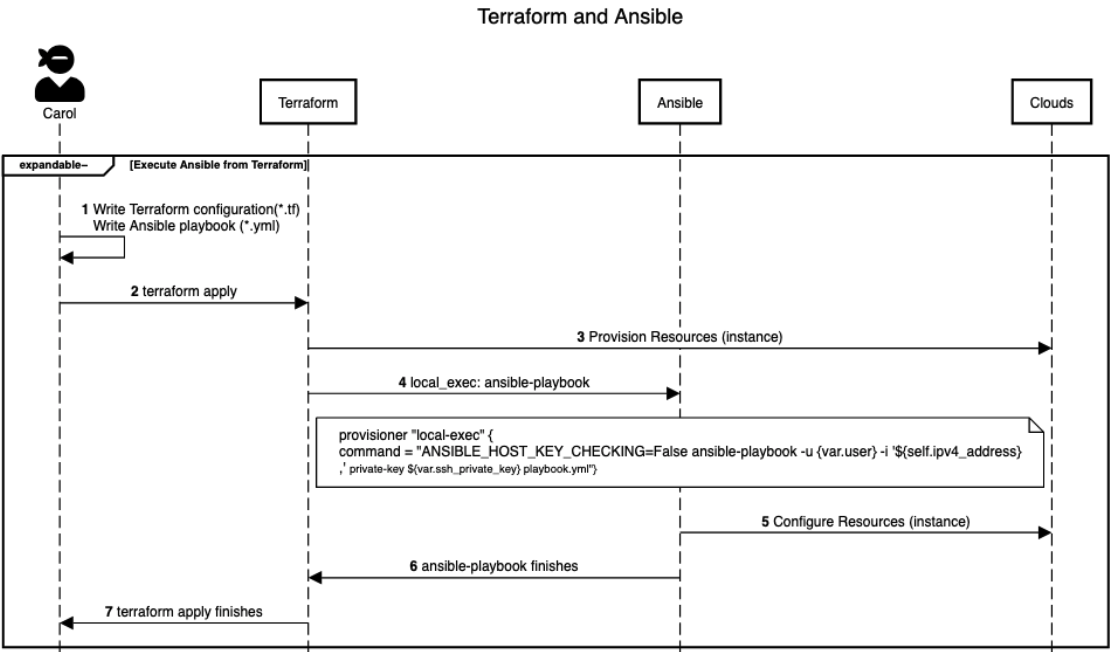

## Prerequisites

Part 1

* Terraform
* Ansible
* AWS Credentials

Part 2

* Terraform Cloud Account/Org with Business license
* Docker

### Set Main Environment Variables

In [ ]:
source ../Scripts/baseline.sh

Be sure to replace `POC_NAME` and `AWS_DEFAULT_REGION` with your own value.

In [ ]:
export POC_NAME=pphan
export WORK_DIR=config/terraform/terraform_ansible
export AWS_DEFAULT_REGION="us-west-2"
printf "$MAIN_DIR\n$WORK_DIR\n$AWS_DEFAULT_REGION"

Create working directory at `config/terraform/terraform_ansible`.

In [ ]:
mkdir -p $WORK_DIR

### AWS Credentials

`terraform` will use credentials set in your environment or through other means as described in the [Terraform documentation](https://www.terraform.io/docs/providers/aws/index.html#environment-variables). This guide will assume you are using the "**Environment Variables**" method.

Add your AWS credentials as two environment variables. Set your `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY` replacing `AAAAAA` with your own values.

In [ ]:
 export AWS_ACCESS_KEY_ID=AAAAAA
 export AWS_SECRET_ACCESS_KEY=AAAAAA
#  export AWS_SESSION_TOKEN=AAAAAA

NOTE: If you use `doormat`, then use this method.

In [ ]:
alias awscredsenv='doormat --smoke-test || doormat -r && eval $(doormat aws -a $account)'
awscredsenv

## Step 1 - Create Terraform Code

In this step, you’ll define the Infrastructure and Instances. You will later run an Ansible playbook that will set up the Apache web server.

Go to the `terraform_ansible` directory, which you created as part of the [Prerequisites](#Prerequisites).

In [ ]:
pushd $WORK_DIR

We're going to create five different files. All `.tf` files can be combined into one file, but breaking them up makes them more digestable.

1. `versions.tf` - specify required providers and versions
1. `main.tf` - define variables and general items
1. `aws.tf` - define aws networking
1. `inventory.tmpl` - terraform template file
1. `instances.tf` - define aws instances - will create this in Step 3.

you’ll define a Instance resource, create three copies of it by specifying `for_each`, and output their IP addresses.

### versions.tf

Create the `versions.tf` file.

In [ ]:
tee versions.tf << EOF
#// versions.tf
terraform {
  required_providers {
    aws = {
      source = "hashicorp/aws"
      version = ">3.0"
    }
  }
}

provider "aws" {
  region = "$AWS_DEFAULT_REGION"
}
EOF

**NOTE:** When `EOF` is surrounded by `""` then the bash shell won't render the variables. In this case, `EOF` is not surrounded by quotes, so `$AWS_DEFAULT_REGION` will render to the value you set.

### main.tf

Create the `main.tf` file.

In [ ]:
cat > main.tf << "EOF"
#// variables.tf
variable "pvt_key" {}
variable "pub_key" {}

#// main.tf
resource "tls_private_key" "ssh" {
  algorithm = "RSA"
  rsa_bits  = 4096
}

resource "local_file" "private_key" {
  sensitive_content         = tls_private_key.ssh.private_key_pem
  filename        = "ssh-key.pem"
  file_permission = "0600"
  provisioner "local-exec" {
    command = "chmod 600 ssh-key.pem"
  }
}

resource "local_file" "public_key" {
  sensitive_content         = tls_private_key.ssh.public_key_openssh
  filename        = "ssh-key-public.pem"
  file_permission = "0600"
}

locals {
  servers = toset(["web1","web2"])
}
EOF

### inventory.tmpl

Create a Terraform template file `inventory.tmpl`. We will use it create an Ansible inventory file.

* There is one Ansible group for the web server instances.
* We also define variables for the hosts.

In [ ]:
cat > inventory.tmpl << "EOF"
web_servers:
  hosts:
%{ for k, v in web_servers ~}
    ${v}:
%{ endfor ~}
  vars:
    ansible_ssh_user: ubuntu
    ansible_ssh_private_key_file: ${ssh_keyfile}
EOF

* The `%{}` contain directives, as opposed to literals or variables.
* The two `~` are to remove excessive newlines and white spaces from the output.
* The `${}` indicate a substitution.

To learn more about the [templatefile](https://www.terraform.io/docs/language/functions/templatefile.html) function, click [here](https://www.terraform.io/docs/language/functions/templatefile.html).

Here is an example of a completed inventory file.

```yaml
web_servers:
  hosts:
    34.219.181.240:
    54.186.135.6:
    35.162.223.237:
  vars:
    ansible_ssh_user: ubuntu
    ansible_ssh_private_key_file: ssh-key.pem
```

### aws.tf

Create the `aws.tf` file. We define the bulk of the AWS configuration in here.

In [ ]:
cat > aws.tf << "EOF"
#// aws.tf
data "aws_region" "current" {}
 
resource "aws_vpc" "main" {
 cidr_block = "10.0.0.0/16"
}

resource "aws_internet_gateway" "gw" {
  vpc_id = aws_vpc.main.id
}

resource "aws_subnet" "main" {
  vpc_id            = aws_vpc.main.id
  cidr_block        = aws_vpc.main.cidr_block
  availability_zone = "${data.aws_region.current.name}a"
}

resource "aws_route_table" "rt" {
 vpc_id = aws_vpc.main.id
 route {
   cidr_block = "0.0.0.0/0"
   gateway_id = aws_internet_gateway.gw.id
 }
}

resource "aws_route_table_association" "route_table_association" {
  subnet_id      = aws_subnet.main.id
  route_table_id = aws_route_table.rt.id
}

data "aws_ami" "ubuntu" {
 most_recent = true
 filter {
   name   = "name"
   values = ["ubuntu/images/hvm-ssd/ubuntu-focal-20.04-amd64-server-*"]
 }
 filter {
   name   = "virtualization-type"
   values = ["hvm"]
 }
 owners = ["099720109477"]
}

resource "aws_key_pair" "aws_key" {
  key_name   = "bitops-ssh-key"
  public_key = tls_private_key.ssh.public_key_openssh
}

resource "aws_security_group" "allow_http" {
  name        = "allow_http"
  description = "Allow HTTP traffic"
  vpc_id      = aws_vpc.main.id
  ingress {
    description = "HTTP"
    from_port   = 80
    to_port     = 80
    protocol    = "tcp"
    cidr_blocks = ["0.0.0.0/0"]
  }
  egress {
    from_port   = 0
    to_port     = 0
    protocol    = "-1"
    cidr_blocks = ["0.0.0.0/0"]
  }
}
 
resource "aws_security_group" "allow_ssh" {
  name        = "allow_ssh"
  description = "Allow SSH traffic"
  vpc_id      = aws_vpc.main.id
  ingress {
    description = "SSHC"
    from_port   = 22
    to_port     = 22
    protocol    = "tcp"
    cidr_blocks = ["0.0.0.0/0"]
  }
  egress {
    from_port   = 0
    to_port     = 0
    protocol    = "-1"
    cidr_blocks = ["0.0.0.0/0"]
  }
}
EOF

## Step 2 - Write an Ansible Playbook

You’ll now create an Ansible playbook that performs the server setup tasks. You’ll instruct Ansible on what to do by writing tasks, which are units of action that are executed on target hosts. Tasks can use built-in functions or specify custom commands to be run.

Tasks that we will define:

* create a new user
* add ssh public key to authorized_users file
* upgrade the installed packages
* install the Apache web server and enable its `mod_rewrite` module.

Ensure that your public and private SSH keys are available and accessible on the machine from which you’re running Terraform and Ansible. These keys will be created by Terraform from the configured in the `main.tf` file.

Note: On Linux, you’ll need to ensure that the private key file has the appropriate permissions. You can set them by running:
```shell
$ chmod 600 your_private_key_location
```

Let's explore the different sections we will put into the playbook.

First, information on which hosts the playbook will run, its name, and if the tasks should be run as root. Add the following lines:

```yaml
---
- name: apache-install
  hosts: all
  become: yes
  remote_user: ec2-user
  become_user: root
```

* Setting `become` to `yes` instructs Ansible to run commands as the superuser
* Specifying `all` for `hosts` allows Ansible to run the tasks on any given server
  * Terraform will pass servers in through the command line

Define the `tasks` section. The first task will create a new, non-root user.

```yaml
  tasks:
    - name: Add the user 'sammy' and add it to 'sudo'
      user:
        name: sammy
        group: sudo
```

* define a list of tasks and then add a task to it
* create a user named `sammy` and add them `sudo` group, which will grant them superuser access using sudo

The next task will add your public SSH key to the user, so you’ll be able to connect to it later on:

```yaml
    - name: Add SSH key to 'sammy'
      authorized_key:
        user: sammy
        state: present
        key: "{{ lookup('file', pub_key) }}"
```

This task will ensure that the public SSH key
* is `present` on the target
* which is looked up from a local file
* `pub_key` is a variable

You’ll supply the value for the `pub_key` variable from Terraform in the next step.

NOTE: Ansible variables are enclosed in double curly braces `{{ }}`.

The next task is to update the software on the Instance using `apt`:

```yaml
    - name: Update all packages
      apt:
        upgrade: dist
        update_cache: yes
        cache_valid_time: 3600
```

The target Instance has the newest versions of available packages and a non-root user available so far. You can now order the installation of Apache and the `mod_rewrite` module by appending the following tasks:

```yaml
    - name: Install apache2
      apt: name=apache2 update_cache=yes state=latest
    - name: Enable mod_rewrite
      apache2_module: name=rewrite state=present
      notify:
        - Restart apache2
  handlers:
    - name: Restart apache2
      service: name=apache2 state=restarted
```

* The "`Install apache2`" task will run the `apt` package manager to install Apache.
* The "`Enable mod_rewrite`" task will ensure that the `mod_rewrite` module is `present`.
* After it’s enabled, you need to restart Apache, However, you can’t restart Apache from the task itself.
* To resolve that, you call a `handler` to issue the restart.

Now, let's create your playbook.

In [ ]:
cat > apache-install.yml <<EOF
- name: apache-install
  hosts: all
  become: yes  
  tasks:
    - name: Add the user 'sammy' and add it to 'sudo'
      user:
        name: sammy
        group: sudo
    - name: Add SSH key to 'sammy'
      authorized_key:
        user: sammy
        state: present
        key: "{{ lookup('file', pub_key) }}"
    - name: Update all packages
      apt:
        upgrade: dist
        update_cache: yes
        cache_valid_time: 3600
    - name: Install apache2
      apt: name=apache2 update_cache=yes state=latest
    - name: Enable mod_rewrite
      apache2_module: name=rewrite state=present
      notify:
        - Restart apache2
  handlers:
    - name: Restart apache2
      service: name=apache2 state=restarted
EOF

This is all you need to define on the Ansible side. You’ll now modify the Instance deployment code to execute this playbook when the Droplets have finished provisioning.

Check the syntax of your Ansible playbook.

In [ ]:
ansible-playbook --syntax-check apache-install.yml
echo $?
printf "\n${YELLOW}Was the syntax check successful? ${GREEN}0 is good. ${RED}Non 0 is bad\n"

## Step 3 - Provision Resources with Terraform and Configure with Ansible

Now that you have defined the actions Ansible will take on the target servers, you’ll modify the Terraform configuration to run it upon Instance creation.

Terraform offers two provisioners that execute commands: `local-exec` and `remote-exec`, which run commands locally or remotely (on the target), respectively.

* `remote-exec` requires connection data, such as type and access keys
* while `local-exec` does everything on the machine Terraform is executing on, and so does not require connection information.
* It’s important to note that `local-exec` runs immediately after the resource you have defined it for has finished provisioning; therefore, it does not wait for the resource to actually boot up. It runs after the cloud platform acknowledges its presence in the system.

### instance.tf

Add provisioner definitions to your Instance to run Ansible after deployment.

In [ ]:
cat > instance.tf << "EOF"
resource "aws_instance" "server" {
  for_each = toset(["web1","web2","web3"])
  ami                         = data.aws_ami.ubuntu.id
  instance_type               = "t3.micro"
  key_name                    = aws_key_pair.aws_key.key_name
  associate_public_ip_address = true
  subnet_id                   = aws_subnet.main.id
  vpc_security_group_ids      = [aws_security_group.allow_http.id, aws_security_group.allow_ssh.id]

  tags = {
    Name = "pphan-${each.key}-instance"
  }

  provisioner "remote-exec" {
    #inline = ["sudo apt update", "sudo apt install python3 -y", "echo Done!"]
    inline = ["hostname", "echo Done!"]

    connection {
      host        = self.public_ip
      type        = "ssh"
      user        = "ubuntu"
      private_key = file(var.pvt_key)
    }
  }

  provisioner "local-exec" {
    command = "ANSIBLE_HOST_KEY_CHECKING=False ansible-playbook -u ubuntu -i '${self.public_ip},' --private-key ${var.pvt_key} -e 'pub_key=${var.pub_key}' apache-install.yml"
  }
}

locals {
  # get json
  instances = [for instance in aws_instance.server : instance.public_ip]
}

#// outputs
output "instance_ip_addresses" {
    value = {
      for instance in aws_instance.server:
      instance.tags.Name => instance.public_ip
    }
    depends_on = [ aws_instance.server ]
}

output "instances" {
    value = local.instances
    depends_on = [ aws_instance.server ]
}

#// Create inventory file for Ansible
resource "local_file" "ansible_inventory" {
  content = templatefile("inventory.tmpl", {
      web_servers = tomap({
        for instance in aws_instance.server:
          instance.tags.Name => instance.public_ip
        }) #local.servers[*]
      ssh_keyfile = local_file.private_key.filename
  })
  #filename = format("%s/%s", abspath(path.root), "${path.root}/inventory.yaml")
  filename = "${path.root}/inventory.yaml"
  depends_on = [aws_instance.server]
}
EOF

Let's explore the `provisioner` stanzas.

```go
  provisioner "remote-exec" {
    inline = ["hostname", "echo Done!"]

    connection {
      host        = self.public_ip
      type        = "ssh"
      user        = "ubuntu"
      private_key = file(var.pvt_key)
    }
  }

  provisioner "local-exec" {
    command = "ANSIBLE_HOST_KEY_CHECKING=False ansible-playbook -u root -i '${self.public_ip},' --private-key ${var.pvt_key} -e 'pub_key=${var.pub_key}' apache-install.yml"
  }
```

Ansible is run locally and connects to the target servers via SSH.

* To run it, you define a `local-exec` provisioner in the Instance definition that runs the `ansible-playbook` command.
* This passes in:
	* `-u` - the username (`ubuntu`)
	* `-i` - the IP of the current Instance retrieved with `${self.public_ip}`
		* can take an IP/fqdn or an Ansible inventory file
	* `--private-key '${var.pvt_key}'` - the SSH private key to use for SSH connection
	* `-e 'pub_key=${var.pub_key}'` - the value of `pub_key` to set in playbook
	* the playbook file to run (`apache-install.yml`)
* Setting the `ANSIBLE_HOST_KEY_CHECKING` environment variable to `False` skips checking if the server was connected to beforehand.

**NOTE:** The `local-exec` provisioner runs without waiting for the Instance to become available. This can result in a race condition where the execution of the playbook may precede the actual availability of the Instance.

To remedy this, you define the `remote-exec` provisioner to contain commands to execute on the target server. For `remote-exec` to execute, the target server must be available. Since `remote-exec` runs before `local-exec` the server will be fully initialized by the time Ansible is invoked.

### tfvars

Specify the location/name of your SSH files.

In [ ]:
private_key_location=ssh-key.pem
public_key_location=ssh-key-public.pem

In [ ]:
cat > terraform.auto.tfvars << EOF
pvt_key = "$private_key_location"
pub_key = "$public_key_location"
EOF

### Terraform Init Plan Apply

Then, deploy the Droplets by running the following command. Remember to replace `private_key_location` and `public_key_location` with the locations of your private and public keys respectively:

In [ ]:
terraform init

In [ ]:
terraform validate && terraform plan -input=false

In [ ]:
terraform apply -auto-approve

Your Instances will provision and then a connection will establish with each. Next, the `remote-exec` provisioner will display its hostname and echo "`Done!`":

```shell
...
aws_instance.server["web1"] (remote-exec): Connecting to remote host via SSH...
aws_instance.server["web1"] (remote-exec):   Host: 52.11.208.154
aws_instance.server["web1"] (remote-exec):   User: ubuntu
aws_instance.server["web1"] (remote-exec):   Password: false
aws_instance.server["web1"] (remote-exec):   Private key: true
aws_instance.server["web1"] (remote-exec):   Certificate: false
aws_instance.server["web1"] (remote-exec):   SSH Agent: true
aws_instance.server["web1"] (remote-exec):   Checking Host Key: false
aws_instance.server["web1"] (remote-exec):   Target Platform: unix
aws_instance.server["web1"] (remote-exec): Connected!
aws_instance.server["web1"] (remote-exec): ip-10-0-236-8
aws_instance.server["web1"] (remote-exec): Done!
...
```

After that, Terraform will run the `local-exec` provisioner for each of the Instances, which executes Ansible. The following output shows this for one of the instances:

Output

```shell
...
aws_instance.server["web1"]: Provisioning with 'local-exec'...
aws_instance.server["web1"] (local-exec): Executing: ["/bin/sh" "-c" "ANSIBLE_HOST_KEY_CHECKING=False ansible-playbook -u ubuntu -i '52.11.208.154,' --private-key ssh-key-pub.pem -e 'pub_key=ssh-key.pem' apache-install.yml"]

aws_instance.server["web1"] (local-exec): PLAY [apache-install] **********************************************************

aws_instance.server["web1"] (local-exec): TASK [Gathering Facts] *********************************************************
aws_instance.server["web1"] (local-exec): ok: [52.11.208.154]

aws_instance.server["web1"] (local-exec): TASK [Add the user 'sammy' and add it to 'sudo'] *******************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): TASK [Add SSH key to 'sammy'] **************************************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): TASK [Update all packages] *****************************************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): TASK [Install apache2] *********************************************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): TASK [Enable mod_rewrite] ******************************************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): RUNNING HANDLER [Restart apache2] **********************************************
aws_instance.server["web1"] (local-exec): changed: [52.11.208.154]

aws_instance.server["web1"] (local-exec): PLAY RECAP *********************************************************************
aws_instance.server["web1"] (local-exec): 52.11.208.154              : ok=7    changed=6    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0
...
```

At the end of the output, you’ll receive a list of the three Instances and their IP addresses:

Output
```shell
instance_ip_addresses = {
  "pphan-web1-instance" = "34.218.48.39"
  "pphan-web2-instance" = "52.34.220.225"
  "pphan-web3-instance" = "54.187.213.24"
}
instances = [
  "34.218.48.39",
  "52.34.220.225",
  "54.187.213.24",
]
```

## Verification

Navigate to one of the IP addresses in your browser. The command below selects the first instance.

In [ ]:
instance_0=$(terraform output -json instances | jq -r '.[0]')
echo $instance_0

The command below does this from the Mac CLI.

In [ ]:
open "http://${instance_0}"

You should see the default Apache welcome page.

This means that Terraform provisioned your servers and your Ansible playbook configured them with Apache successfully.

To check that the SSH key was correctly added to `sammy` on the provisioned instances, connect to one of them with the following command:

In [ ]:
ssh -i $private_key_location sammy@${instance_0} hostname

You should see output similar to the following:

```shell
ip-10-0-214-105
```

This confirms that the SSH key was provisioned correctly and that Ansible configured `sammy` and her authorized keys on the instances.

In this tutorial, you have added in Ansible playbook execution as a `local-exec` provisioner to your Instance definition. To ensure that the server is available for connections, you’ve included the `remote-exec` provisioner, which can serve to install the python3 prerequisite for Ansible, after which Ansible will run.

## Conclusion - NEEDS REVISION

Terraform and Ansible together form a flexible workflow for spinning up servers with the needed software and hardware configurations. Running Ansible directly as part of the Terraform deployment process allows you to have the servers up and bootstrapped with dependencies for your development work and applications much faster.

In the next section, we will cover what you need to move this to Terraform Cloud and Terraform Cloud Agents. However, if you stop and remove your environment, then please go to the [Clean Up](#Clean-Up) section.

# Terraform Agent with Ansible

## Overview

You're management really likes what you have done, but now they want you to use Terraform Cloud Business Tier so that you can take advantage of Enterprise Features like Collaboration, Governance, Cloud Agents, etc.

With Cloud Agents you can add additional tools like Ansible, the AWS CLI, etc to make deploying resources simple and consistent.

In this tutorial, you will:
* Build a custom Terraform Cloud Agent (aka tfc-agent) that includes Ansible
* Start custom Terraform Cloud Agent
* Deploy resource with custom tfc-agent

## Prerequisites

* Terraform Cloud Account and Organization
* Terraform Cloud Agent token
* Docker

## Step 1 - Create custom Terraform Cloud Agent with Ansible

Create a custom container that has Ansible on it.

### Dockerfile for Custom Agent

#### Ansible config modification

With the default Ansible configuration we get a `too long for Unix domain socket` error. To workaround this, we will modify the `ssh_connection` section.

In [ ]:
cat > ansible.cfg <<EOF
[ssh_connection]
control_path_dir = /tmp/.ansible/cp
control_path = %(directory)s/%%C
EOF

In [ ]:
cat > Dockerfile << EOF
FROM hashicorp/tfc-agent
USER root

# Uncomment this if you get hash mismatch errors when using apt
# RUN mkdir -p /etc/gcrypt && echo all > /etc/gcrypt/hwf.deny

RUN apt update && DEBIAN_FRONTEND=noninteractive apt-get install -y \
  ansible \
  net-tools \
  nmap
RUN  apt-get clean && \
  rm -rf /var/lib/apt
COPY ansible.cfg /etc/ansible/ansible.cfg
USER tfc-agent
EOF

### Docker Build

If you have pulled hashicorp/tfc-agent in the past make sure you pull the latest version.

Pull latest version of hashicorp/tfc-agent.

In [ ]:
docker pull hashicorp/tfc-agent:latest

In [ ]:
docker build -t tfc-agent-ansible .

In [ ]:
docker image ls | grep -E "REPO|agent"

Be sure to replace `TF_ORG` and `TF_WS_NAME` with your own values.

In [ ]:
TF_ORG=pphan
TF_WS_NAME=terraform_ansible

In [ ]:
tee remote_backend.tf <<-EOF
terraform {
  backend "remote" {
    hostname = "app.terraform.io"
    organization = "${TF_ORG}"
    workspaces {
      name = "${TF_WS_NAME}"
    }
  }
}
EOF

Migrate state

In [ ]:
printf "yes\n" | terraform init

In [ ]:
mv terraform.tfstate terraform.tfstate.bak

### Set credentials in TFC Workspace

In [ ]:
account="se_demos_dev" tf_hostname="app.terraform.io"
alias awstfcpush='doormat --smoke-test || doormat -r && doormat aws -a ${account} --tf-push --tf-workspace ${TF_WS_NAME} --tf-organization ${TF_ORG} --tf-hostname ${tf_hostname}'
awstfcpush

## Step 2 - Start Terraform Cloud Agent

In [ ]:
export TFC_AGENT_TOKEN=REPLACEME TFC_AGENT_NAME=agent

In [ ]:
docker run --rm --name ansible \
  -e TFC_AGENT_TOKEN -e TFC_AGENT_NAME tfc-agent-ansible &

## Step 3 - Deploy Resource with Terraform Cloud Agent

Assuming your three instances are already running, you can have Terraform `replace` one of the instances and reapply the Ansible playbook via the Terraform Cloud Agent and store its state in Terraform Cloud.

In [ ]:
terraform apply -replace="aws_instance.server[\"web1\"]" -auto-approve

## Verification

Navigate to one of the IP addresses in your browser. The command below selects the first instance.

In [ ]:
instance_0=$(terraform output -json instances | jq -r '.[0]')
echo $instance_0

The command below does this from the Mac CLI.

In [ ]:
open "http://${instance_0}"

You should see the default Apache welcome page.

This means that Terraform provisioned your servers and your Ansible playbook configured them with Apache successfully.

## Conclusion

## Clean Up

### Destroy Provisioned Resources

In [ ]:
terraform destroy -auto-approve

### Destroy File Artifacts

In [ ]:
popd && pwd

In [ ]:
rm -rf $WORK_DIR

### Destroy tfc-agent container

In [ ]:
docker stop ansible

## References

* https://www.digitalocean.com/community/tutorials/how-to-use-ansible-with-terraform-for-configuration-management
* [Consuming and decoding JSON in Terraform](https://dev.to/lucassha/consuming-and-decoding-json-in-terraform-309p)
* https://stackoverflow.com/questions/45489534/best-way-currently-to-create-an-ansible-inventory-from-terraform

### Issues

* https://github.com/hashicorp/terraform-provider-local/issues/19
* https://github.com/ansible/ansible/issues/11536